In [1]:
import numpy      as    np
import h5py       as    h5
import ismrmrd    as    mrd
import ismrmrd.xsd
from   matplotlib import   pyplot as plt
# import seaborn    as    sns

In [2]:
def returnHeaderAndData (h5RawFilePath, dataElement='/dataset'):

   rawDataArray = mrd.Dataset(h5RawFilePath, dataElement, True)
   rawDataArrayHeader = ismrmrd.xsd.CreateFromDocument(rawDataArray.read_xml_header())

   enc = rawDataArrayHeader.encoding[0]

   # Matrix size
   eNx = enc.encodedSpace.matrixSize.x
   eNy = enc.encodedSpace.matrixSize.y
   # eNz = enc.encodedSpace.matrixSize.z

   if enc.encodingLimits.slice != None:
      eNz = enc.encodingLimits.slice.maximum + 1
   else:
      eNz = 1

   if enc.encodingLimits.repetition != None:
      eNt = enc.encodingLimits.repetition.maximum + 1
   else:
      eNt = 1

   allKspace = np.zeros((rawDataArray.read_acquisition(0).data.shape[0],
                         rawDataArray.read_acquisition(0).data.shape[1],
                         eNy, eNz, eNt), dtype=np.complex64)

   for i in range(rawDataArray.number_of_acquisitions()):
      thisAcq = rawDataArray.read_acquisition(i)
      allKspace[:, :, thisAcq.idx.kspace_encode_step_1, thisAcq.idx.slice, 0] = thisAcq.data

   return rawDataArrayHeader, allKspace


## First - read in (fully sampled) calibration data from array coil

In [3]:
calDataArrayHeader, calDataArray = returnHeaderAndData('./ScanArchive_20190529_090502374_converted.h5')

In [4]:
imageSpace = np.fft.fftshift(np.fft.fft2(calDataArray, axes=(1,2)), axes=(1,2))

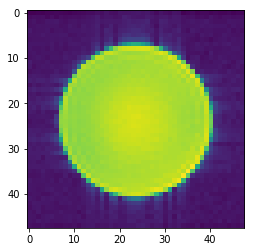

In [5]:
for t in range(1):
   for s in range (1):
      reconnedImage = np.sqrt(np.sum((abs(imageSpace[:, :, :, s, t])), axis=0))
      plt.imshow(reconnedImage)

## Now - read in data from body coil.  Not absolutely necessary - but might be useful

In [6]:
calDataBodyHeader, calDataBody = returnHeaderAndData('./ScanArchive_20190529_090622648_converted.h5')

In [7]:
imageSpace = np.fft.fftshift(np.fft.fft2(calDataBody, axes=(1,2)), axes=(1,2))

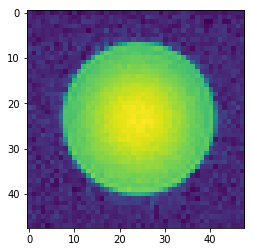

In [8]:
for t in range(1):
   for s in range (1):
      reconnedImage = np.sqrt(np.sum((abs(imageSpace[:, :, :, s, t])), axis=0))
      plt.imshow(reconnedImage)

In [9]:
imageSpace = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(calDataBody, axes=(1,2)), axes=(1,2)), axes=(1,2))

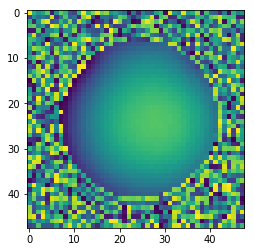

In [10]:
for t in range(1):
   for s in range (1):
      reconnedImage = np.sum(np.angle(imageSpace[:, :, :, s, t]), axis=0)
      plt.imshow(reconnedImage)

## Read in noise data from array coil.  No need to reconstruct, but just as a sanity check.

In [11]:
noiseDataArrayHeader, noiseDataArray = returnHeaderAndData('./ScanArchive_20190529_090902358_converted.h5')

In [12]:
imageSpace = np.fft.fftshift(np.fft.fft2(noiseDataArray, axes=(1,2)), axes=(1,2))

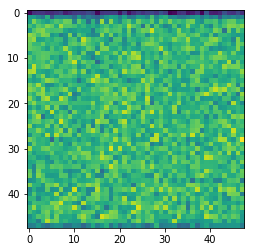

In [13]:
for t in range(1):
   for s in range (1):
      reconnedImage = np.sqrt(np.sum((abs(imageSpace[:, :, :, s, t])), axis=0))
      plt.imshow(reconnedImage)

In [14]:
enc = noiseDataArrayHeader.encoding[0]

rNx = enc.reconSpace.matrixSize.x
rNy = enc.reconSpace.matrixSize.y
rNz = enc.reconSpace.matrixSize.z

In [15]:
enc

In [16]:
rNx, rNy, rNz

(256, 256, 1)

### Create and artificially sub-sampled (accelerated) of data from the array coil data (R = 2)

In [17]:
subSampledKSpace = np.zeros((calDataArray.shape), dtype=np.complex64)

subSampledKSpace[:, :, ::2, :, :] = calDataArray[:, :, ::2, :, :]

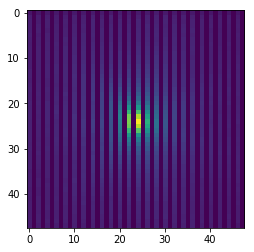

In [18]:
for t in range(1):
   for s in range (1):
      reconnedImage = np.sqrt(np.sum((abs(subSampledKSpace[:, :, :, s, t])), axis=0))
      plt.imshow(reconnedImage)

In [19]:
imageSpace = np.fft.fftshift(np.fft.fft2(subSampledKSpace, axes=(1,2)), axes=(1,2))

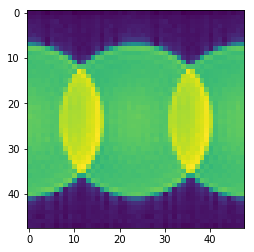

In [20]:
for t in range(1):
   for s in range (1):
      reconnedImage = np.sqrt(np.sum((abs(imageSpace[:, :, :, s, t])), axis=0))
      plt.imshow(reconnedImage)